### Twitter Sentiment Analysis
The purpose of this project is to predict sentiment for the given Twitter post using Python.

In [33]:
#importing the packages
from collections import Counter
import nltk
import pandas as pd
import re as regex
import numpy as np
import plotly
from plotly import graph_objs
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from time import time
try:
    import gensim
except NameError:
    print("gensim package is not installed")

In [48]:
#importing the packeges for plotly graph
from IPython.core.interactiveshell import InteractiveShell     #An enhanced, interactive shell for Python
#‘all’, ‘last’, ‘last_expr’ or ‘none’, ‘last_expr_or_assign’
#specifying which nodes should be run interactively 
import plotly 
plotly.tools.set_credentials_file(username='KunalBhashkar', api_key='3ImJpD57ThNbPx117FsM')
InteractiveShell.ast_node_interactivity = "all"   #Options:	'all','last','last_expr','none','last_expr_or_assign'

import numpy as np # linear algebra
import pandas as pd # data processing

#Plotly Offline brings interactive Plotly graphs to the offline (local) environment
import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as gobj
import plotly.plotly as plty
from plotly.graph_objs import *
py.init_notebook_mode(connected=True)  # initiate notebook for offline plot

In [49]:
#Emotion class to check whether it is negative or positive
class EmoticonDetector:
    emoticons = {}

    def __init__(self, emoticon_file="./coding/ml-twitter-sentiment-analysis-develop/data/emoticons.txt"):
        from pathlib import Path
        content = Path(emoticon_file).read_text()
        positive = True
        for line in content.split("\n"):
            if "positive" in line.lower():
                positive = True
                continue
            elif "negative" in line.lower():
                positive = False
                continue

            self.emoticons[line] = positive

    def is_positive(self, emoticon):
        if emoticon in self.emoticons:
            return self.emoticons[emoticon]
        return False

    def is_emoticon(self, to_check):
        return to_check in self.emoticons

In [50]:
#Class to initialize Twitter data
class TwitterData_Initialize():
    data = []
    processed_data = []
    wordlist = []
    data_model = None
    data_labels = None
    is_testing = False    
    def initialize(self, csv_file, is_testing_set=False,from_cached=None):
        if from_cached is not None:
            self.data_model = pd.read_csv(from_cached)
            return

        self.is_testing = is_testing_set

        if not is_testing_set:
            self.data = pd.read_csv(csv_file, header=0, names=["id", "emotion", "text"])
            self.data = self.data[self.data["emotion"].isin(["positive", "negative", "neutral"])]
        else:
            self.data = pd.read_csv(csv_file, header=0, names=["id", "text"],dtype={"id":"int64","text":"str"},nrows=4000)
            not_null_text = 1 ^ pd.isnull(self.data["text"])
            not_null_id = 1 ^ pd.isnull(self.data["id"])
            self.data = self.data.loc[not_null_id & not_null_text, :]

        self.processed_data = self.data
        self.wordlist = []
        self.data_model = None
        self.data_labels = None

In [51]:
#Reading and initialization of twitter data
data = TwitterData_Initialize()
data.initialize("./coding/ml-twitter-sentiment-analysis-develop/data/train.csv")
data.processed_data.head(5)

,id,emotion,text
0,635769805279248384,negative,Not Available
1,635930169241374720,neutral,IOS 9 App Transport Security. Mm need to check...
2,635950258682523648,neutral,"Mar if you have an iOS device, you should down..."
3,636030803433009153,negative,@jimmie_vanagon my phone does not run on lates...
4,636100906224848896,positive,Not sure how to start your publication on iOS?...


##### Distribution of Data in negative,positive and neutral

In [52]:
#Distribution of data
df = data.processed_data
neg = len(df[df["emotion"] == "negative"])
pos = len(df[df["emotion"] == "positive"])
neu = len(df[df["emotion"] == "neutral"])
dist = [
    graph_objs.Bar(
        x=["negative","neutral","positive"],
        y=[neg, neu, pos],
)]
plotly.offline.iplot({"data":dist, "layout":graph_objs.Layout(title="Data Distribution in training set")})

#### Preprocessing steps

In [53]:
#Cleaning process
class TwitterCleanuper:
    def iterate(self):
        for cleanup_method in [self.remove_urls,
                               self.remove_usernames,
                               self.remove_na,
                               self.remove_special_chars,
                               self.remove_numbers]:
            yield cleanup_method

    @staticmethod
    def remove_by_regex(tweets, regexp):
        tweets.loc[:, "text"].replace(regexp, "", inplace=True)
        return tweets

    def remove_urls(self, tweets):
        return TwitterCleanuper.remove_by_regex(tweets, regex.compile(r"http.?://[^\s]+[\s]?"))

    def remove_na(self, tweets):
        return tweets[tweets["text"] != "Not Available"]

    def remove_special_chars(self, tweets):  # it unrolls the hashtags to normal words
        for remove in map(lambda r: regex.compile(regex.escape(r)), [",", ":", "\"", "=", "&", ";", "%", "$",
                                                                     "@", "%", "^", "*", "(", ")", "{", "}",
                                                                     "[", "]", "|", "/", "\\", ">", "<", "-",
                                                                     "!", "?", ".", "'",
                                                                     "--", "---", "#"]):
            tweets.loc[:, "text"].replace(remove, "", inplace=True)
        return tweets

    def remove_usernames(self, tweets):
        return TwitterCleanuper.remove_by_regex(tweets, regex.compile(r"@[^\s]+[\s]?"))

    def remove_numbers(self, tweets):
        return TwitterCleanuper.remove_by_regex(tweets, regex.compile(r"\s?[0-9]+\.?[0-9]*"))

In [54]:
#Class to clean the twitter data
class TwitterData_Cleansing(TwitterData_Initialize):
    def __init__(self, previous):
        self.processed_data = previous.processed_data
        
    def cleanup(self, cleanuper):
        t = self.processed_data
        for cleanup_method in cleanuper.iterate():
            if not self.is_testing:
                t = cleanup_method(t)
            else:
                if cleanup_method.__name__ != "remove_na":
                    t = cleanup_method(t)

        self.processed_data = t

In [55]:
#Finally cleaning the data
data = TwitterData_Cleansing(data)
data.cleanup(TwitterCleanuper())
data.processed_data.head(5)

/home/kunal/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4619: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,id,emotion,text
1,635930169241374720,neutral,IOS App Transport Security Mm need to check if...
2,635950258682523648,neutral,Mar if you have an iOS device you should downl...
3,636030803433009153,negative,my phone does not run on latest IOS which may ...
4,636100906224848896,positive,Not sure how to start your publication on iOS ...
5,636176272947744772,neutral,Two Dollar Tuesday is here with Forklift Quick...


#### Tokenization & stemming

In [56]:
#Class to Normalize and Tokenize the dataset
class TwitterData_TokenStem(TwitterData_Cleansing):
    def __init__(self, previous):
        self.processed_data = previous.processed_data
        
    def stem(self, stemmer=nltk.PorterStemmer()):
        def stem_and_join(row):
            row["text"] = list(map(lambda str: stemmer.stem(str.lower()), row["text"]))
            return row

        self.processed_data = self.processed_data.apply(stem_and_join, axis=1)

    def tokenize(self, tokenizer=nltk.word_tokenize):
        def tokenize_row(row):
            row["text"] = tokenizer(row["text"])
            row["tokenized_text"] = [] + row["text"]
            return row

        self.processed_data = self.processed_data.apply(tokenize_row, axis=1)

In [57]:
#Finally process the data for stemming
data = TwitterData_TokenStem(data)
data.tokenize()
data.stem()
data.processed_data.head(5)

,id,emotion,text,tokenized_text
1,635930169241374720,neutral,"[io, app, transport, secur, mm, need, to, chec...","[IOS, App, Transport, Security, Mm, need, to, ..."
2,635950258682523648,neutral,"[mar, if, you, have, an, io, devic, you, shoul...","[Mar, if, you, have, an, iOS, device, you, sho..."
3,636030803433009153,negative,"[my, phone, doe, not, run, on, latest, io, whi...","[my, phone, does, not, run, on, latest, IOS, w..."
4,636100906224848896,positive,"[not, sure, how, to, start, your, public, on, ...","[Not, sure, how, to, start, your, publication,..."
5,636176272947744772,neutral,"[two, dollar, tuesday, is, here, with, forklif...","[Two, Dollar, Tuesday, is, here, with, Forklif..."


In [58]:
#Method to get most common words from preprocessed data
words = Counter()
for idx in data.processed_data.index:
    words.update(data.processed_data.loc[idx, "text"])
#Getting most common words 
words.most_common(5)

[('the', 3744), ('to', 2477), ('i', 1667), ('a', 1620), ('on', 1557)]

In [59]:
#Removing the stopwords
stopwords=nltk.corpus.stopwords.words("english")
whitelist = ["n't", "not"]
for idx, stop_word in enumerate(stopwords):
    if stop_word not in whitelist:
        del words[stop_word]
words.most_common(5)

# output
# [('may', 1027), ('tomorrow', 764), ('day', 526), ('go', 499), ('thi', 495)]

[('may', 1027), ('tomorrow', 764), ('day', 526), ('go', 499), ('thi', 495)]

In [65]:
#Class to build the word list
class TwitterData_Wordlist(TwitterData_TokenStem):
    def __init__(self, previous):
        self.processed_data = previous.processed_data
        
    whitelist = ["n't","not"]
    wordlist = []
        
    def build_wordlist(self, min_occurrences=3, max_occurences=500, stopwords=nltk.corpus.stopwords.words("english"),
                       whitelist=None):
        self.wordlist = []
        whitelist = self.whitelist if whitelist is None else whitelist
        import os
        if os.path.isfile("./coding/ml-twitter-sentiment-analysis-develop/data/wordlist.csv"):
            word_df = pd.read_csv("./coding/ml-twitter-sentiment-analysis-develop/data/wordlist.csv")
            word_df = word_df[word_df["occurrences"] > min_occurrences]
            self.wordlist = list(word_df.loc[:, "word"])
            return

        words = Counter()
        for idx in self.processed_data.index:
            words.update(self.processed_data.loc[idx, "text"])

        for idx, stop_word in enumerate(stopwords):
            if stop_word not in whitelist:
                del words[stop_word]

        word_df = pd.DataFrame(data={"word": [k for k, v in words.most_common() if min_occurrences < v < max_occurences],
                                     "occurrences": [v for k, v in words.most_common() if min_occurrences < v < max_occurences]},
                               columns=["word", "occurrences"])

        word_df.to_csv("./coding/ml-twitter-sentiment-analysis-develop/data/wordlist.csv", index_label="idx")
        self.wordlist = [k for k, v in words.most_common() if min_occurrences < v < max_occurences]

In [66]:
#Applying the method on dataset
data = TwitterData_Wordlist(data)
data.build_wordlist()

In [67]:
#Plotting the words which is most common
words = pd.read_csv("./coding/ml-twitter-sentiment-analysis-develop/data/wordlist.csv")
x_words = list(words.loc[0:10,"word"])
x_words.reverse()
y_occ = list(words.loc[0:10,"occurrences"])
y_occ.reverse()

dist = [
    graph_objs.Bar(
        x=y_occ,
        y=x_words,
        orientation="h"
)]
py.iplot({"data":dist, "layout":graph_objs.Layout(title="Most common word in wordlist")})

#### Bag of words approach

In [68]:
#Class to define twitter data bag of words
class TwitterData_BagOfWords(TwitterData_Wordlist):
    def __init__(self, previous):
        self.processed_data = previous.processed_data
        self.wordlist = previous.wordlist
    
    def build_data_model(self):
        label_column = []
        if not self.is_testing:
            label_column = ["label"]

        columns = label_column + list(
            map(lambda w: w + "_bow",self.wordlist))
        labels = []
        rows = []
        for idx in self.processed_data.index:
            current_row = []

            if not self.is_testing:
                # add label
                current_label = self.processed_data.loc[idx, "emotion"]
                labels.append(current_label)
                current_row.append(current_label)

            # add bag-of-words
            tokens = set(self.processed_data.loc[idx, "text"])
            for _, word in enumerate(self.wordlist):
                current_row.append(1 if word in tokens else 0)

            rows.append(current_row)

        self.data_model = pd.DataFrame(rows, columns=columns)
        self.data_labels = pd.Series(labels)
        return self.data_model, self.data_labels

In [69]:
#processing bag of words
data = TwitterData_BagOfWords(data)
bow, labels = data.build_data_model()
bow.head(5)

,label,go_bow,thi_bow,wa_bow,not_bow,im_bow,see_bow,time_bow,get_bow,like_bow,...,leadership_bow,snp_bow,tsiprass_bow,parliamentari_bow,alexi_bow,farag_bow,girlfriend_bow,castl_bow,crasher_bow,fiddl_bow
0,neutral,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,neutral,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,negative,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,positive,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,neutral,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
#Grouped the bag of words according to label
grouped = bow.groupby(["label"]).sum()
words_to_visualize = []
sentiments = ["positive","negative","neutral"]
#get the most 7 common words for every sentiment
for sentiment in sentiments:
    words = grouped.loc[sentiment,:]
    words.sort_values(inplace=True,ascending=False)
    for w in words.index[:7]:
        if w not in words_to_visualize:
            words_to_visualize.append(w)
            
            
#visualize it
plot_data = []
for sentiment in sentiments:
    plot_data.append(graph_objs.Bar(
            x = [w.split("_")[0] for w in words_to_visualize],
            y = [grouped.loc[sentiment,w] for w in words_to_visualize],
            name = sentiment
    ))
    
py.iplot({
        "data":plot_data,
        "layout":graph_objs.Layout(title="Most common words across sentiments")
    })
    

#### Feature Extraction

In [71]:
#Class to detect emotion
class EmoticonDetector:
    emoticons = {}

    def __init__(self, emoticon_file="./coding/ml-twitter-sentiment-analysis-develop/data/emoticons.txt"):
        from pathlib import Path
        content = Path(emoticon_file).read_text()
        positive = True
        for line in content.split("\n"):
            if "positive" in line.lower():
                positive = True
                continue
            elif "negative" in line.lower():
                positive = False
                continue

            self.emoticons[line] = positive

    def is_positive(self, emoticon):
        if emoticon in self.emoticons:
            return self.emoticons[emoticon]
        return False

    def is_emoticon(self, to_check):
        return to_check in self.emoticons

In [72]:
#Creating a class for feature extraction purpose
class TwitterData_ExtraFeatures(TwitterData_Wordlist):
    def __init__(self):
        pass
    
    def build_data_model(self):
        extra_columns = [col for col in self.processed_data.columns if col.startswith("number_of")]
        label_column = []
        if not self.is_testing:
            label_column = ["label"]

        columns = label_column + extra_columns + list(
            map(lambda w: w + "_bow",self.wordlist))
        
        labels = []
        rows = []
        for idx in self.processed_data.index:
            current_row = []

            if not self.is_testing:
                # add label
                current_label = self.processed_data.loc[idx, "emotion"]
                labels.append(current_label)
                current_row.append(current_label)

            for _, col in enumerate(extra_columns):
                current_row.append(self.processed_data.loc[idx, col])

            # add bag-of-words
            tokens = set(self.processed_data.loc[idx, "text"])
            for _, word in enumerate(self.wordlist):
                current_row.append(1 if word in tokens else 0)

            rows.append(current_row)

        self.data_model = pd.DataFrame(rows, columns=columns)
        self.data_labels = pd.Series(labels)
        return self.data_model, self.data_labels
    
    def build_features(self):
        def count_by_lambda(expression, word_array):
            return len(list(filter(expression, word_array)))

        def count_occurences(character, word_array):
            counter = 0
            for j, word in enumerate(word_array):
                for char in word:
                    if char == character:
                        counter += 1

            return counter

        def count_by_regex(regex, plain_text):
            return len(regex.findall(plain_text))

        self.add_column("splitted_text", map(lambda txt: txt.split(" "), self.processed_data["text"]))

        # number of uppercase words
        uppercase = list(map(lambda txt: count_by_lambda(lambda word: word == word.upper(), txt),
                             self.processed_data["splitted_text"]))
        self.add_column("number_of_uppercase", uppercase)

        # number of !
        exclamations = list(map(lambda txt: count_occurences("!", txt),
                                self.processed_data["splitted_text"]))

        self.add_column("number_of_exclamation", exclamations)

        # number of ?
        questions = list(map(lambda txt: count_occurences("?", txt),
                             self.processed_data["splitted_text"]))

        self.add_column("number_of_question", questions)

        # number of ...
        ellipsis = list(map(lambda txt: count_by_regex(regex.compile(r"\.\s?\.\s?\."), txt),
                            self.processed_data["text"]))

        self.add_column("number_of_ellipsis", ellipsis)

        # number of hashtags
        hashtags = list(map(lambda txt: count_occurences("#", txt),
                            self.processed_data["splitted_text"]))

        self.add_column("number_of_hashtags", hashtags)

        # number of mentions
        mentions = list(map(lambda txt: count_occurences("@", txt),
                            self.processed_data["splitted_text"]))

        self.add_column("number_of_mentions", mentions)

        # number of quotes
        quotes = list(map(lambda plain_text: int(count_occurences("'", [plain_text.strip("'").strip('"')]) / 2 +
                                                 count_occurences('"', [plain_text.strip("'").strip('"')]) / 2),
                          self.processed_data["text"]))

        self.add_column("number_of_quotes", quotes)

        # number of urls
        urls = list(map(lambda txt: count_by_regex(regex.compile(r"http.?://[^\s]+[\s]?"), txt),
                        self.processed_data["text"]))

        self.add_column("number_of_urls", urls)

        # number of positive emoticons
        ed = EmoticonDetector()
        positive_emo = list(
            map(lambda txt: count_by_lambda(lambda word: ed.is_emoticon(word) and ed.is_positive(word), txt),
                self.processed_data["splitted_text"]))

        self.add_column("number_of_positive_emo", positive_emo)

        # number of negative emoticons
        negative_emo = list(map(
            lambda txt: count_by_lambda(lambda word: ed.is_emoticon(word) and not ed.is_positive(word), txt),
            self.processed_data["splitted_text"]))

        self.add_column("number_of_negative_emo", negative_emo)
        
    def add_column(self, column_name, column_content):
        self.processed_data.loc[:, column_name] = pd.Series(column_content, index=self.processed_data.index)

In [73]:
#Twitter data Feature Extraction
data = TwitterData_ExtraFeatures()
data.initialize("./coding/ml-twitter-sentiment-analysis-develop/data/train.csv")
data.build_features()
data.cleanup(TwitterCleanuper())
data.tokenize()
data.stem()
data.build_wordlist()
data_model, labels = data.build_data_model()

/home/kunal/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4619: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



#### Classification of Twitter dataset 

In [74]:
#Importing the packages
import random
seed = 666
random.seed(seed)

In [75]:
#Method for test classification
def test_classifier(X_train, y_train, X_test, y_test, classifier):
    print("")
    print("******Classification of Twitter Sentiment Analysis******")
    classifier_name = str(type(classifier).__name__)
    print("Testing " + classifier_name)
    now = time()
    list_of_labels = sorted(list(set(y_train)))
    model = classifier.fit(X_train, y_train)
    print("Learing time {0}s".format(time() - now))
    now = time()
    predictions = model.predict(X_test)
    print("Predicting time {0}s".format(time() - now))

    precision = precision_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    recall = recall_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    print("************ Results ************")
    print("            Negative     Neutral     Positive")
    print("F1       " + str(f1))
    print("Precision" + str(precision))
    print("Recall   " + str(recall))
    print("Accuracy " + str(accuracy)) 

    return precision, recall, accuracy, f1

#### XGBoost Machine Learning Algorithm

In [77]:
from xgboost import XGBClassifier as XGBoostClassifier

In [78]:
X_train, X_test, y_train, y_test = train_test_split(data_model.iloc[:, 1:], data_model.iloc[:, 0],
                                                    train_size=0.7, stratify=data_model.iloc[:, 0],
                                                    random_state=seed)
precision, recall, accuracy, f1 = test_classifier(X_train, y_train, X_test, y_test, XGBoostClassifier(seed=seed))

/home/kunal/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.




******Classification of Twitter Sentiment Analysis******
Testing XGBClassifier
Learing time 70.33846664428711s
Predicting time 0.1466081142425537s
************ Results ************
            Negative     Neutral     Positive
F1       [0.16716418 0.41090555 0.69450317]
Precision[0.37837838 0.47845805 0.59082734]
Recall   [0.10727969 0.36006826 0.84230769]
Accuracy 0.5507068223724647


/home/kunal/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.



In [79]:
#Method to find cross validating accuracy as below
def cv(classifier, X_train, y_train): 
    classifier_name = str(type(classifier).__name__)
    now = time()
    print("Crossvalidating " + classifier_name + "...")
    accuracy = [cross_val_score(classifier, X_train, y_train, cv=8, n_jobs=-1)]
    print("Crosvalidation completed in {0}s".format(time() - now))
    print("Accuracy: " + str(accuracy[0]))
    print("Average accuracy: " + str(np.array(accuracy[0]).mean()))    
    return accuracy

In [81]:
xgb_acc = cv(XGBoostClassifier(seed=seed),data_model.iloc[:, 1:], data_model.iloc[:, 0])

Crossvalidating XGBClassifier...


/home/kunal/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/kunal/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/kunal/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/home/kunal/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but

Crosvalidation completed in 361.70437574386597s
Accuracy: [0.53608247 0.47787611 0.39823009 0.30383481 0.34070796 0.50812408
 0.47119645 0.53994083]
Average accuracy: 0.44699910024231854


(0.0, 1.0)

(0.0, 1.05)

Text(0.5,0,'Recall')

Text(0,0.5,'Precision')

Text(0.5,1,'Precision Recall Curve')

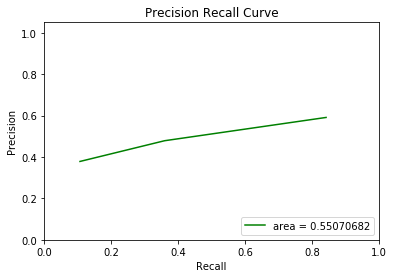

In [84]:
import matplotlib.pyplot as plt
plt.plot(recall, precision, label='area = %0.8f' % accuracy, color="green")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.legend(loc="lower right")
plt.show()